I have read before that Hoare Partitioning is faster by a constant factor than the Lomuto Partitioning. This will clearly have an important impact on the performance of Quick Sort. Here, I wanted to check that and see if it holds true in practice, and if so, what that constant factor might be. Let's define the two partitioning schemes below:

In [6]:
def Lomuto_Partitioning(A, p, r):
    x = A[r]
    i = p - 1
    for j in range(p, r):
        if A[j] <= x:
            i += 1
            A[i], A[j] = A[j], A[i]
    A[i+1], A[r] = A[r], A[i+1]
    return i + 1

def Hoare_Partitioning(A, p, r):
    x = A[p]
    i = p - 1
    j = r + 1
    while True:
        while True:
            j = j - 1
            if A[j] <= x:
                break
        while True:
            i = i + 1
            if A[i] >= x:
                break
        if i < j:
            A[i], A[j] = A[j], A[i]
        else:
            return j

Let us quickly test the functions:

In [7]:
l = [-1, 8,3,2,1,0,5,4]
Lomuto_Partitioning(l, 0, len(l) - 1)
print(l)
l = [3,2,1,0,5,4]
Hoare_Partitioning(l, 0, len(l) - 1)
print(l)

[-1, 3, 2, 1, 0, 4, 5, 8]
[0, 2, 1, 3, 5, 4]


Now, lets write a test harness to compute the average execution time they both take. Since both algos are $O(n)$, we expect a linear graph.

In [8]:
import random, timeit
import matplotlib.pyplot as plt
%matplotlib inline

def getTimes(algo, max_n, k):
    ret = []
    for i in range(max_n):
        acc = 0
        for t in range(k):
            samples = random.sample(range(1000000), i + 1)
            t = timeit.Timer(lambda: algo(samples, 0, i - 1))
            acc += t.timeit(number=10)
        ret.append(acc/k)
    return ret

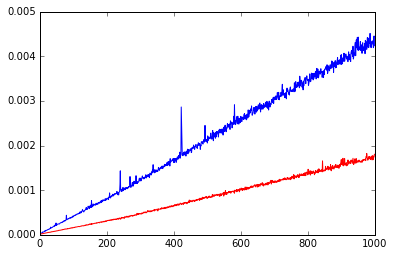

In [9]:
N = 1000; repeats = 10
ltimes = getTimes(Lomuto_Partitioning, N, repeats)
htimes = getTimes(Hoare_Partitioning, N, repeats)
plt.plot(ltimes, 'b')
plt.plot(htimes, 'r')

I guess that is the result we were looking for. Clearly, the Hoare Partitioning scheme is significantly faster than Lomuto Partitioning. The spikes are a result of a low number of repeats (10). They appear very differently in different runs. I reckon that they will smoothen out with a larger number. However, considering that the above timing function is $O(N^2)$, I'll quickly loose my patience. Let us now try to evaluate the ratio by fitting in a linear regression. Assuming that $T(0) = 0$ for both methods, we can model the times as:

$$T_{Lomuto}(n) = \alpha n$$
$$T_{Hoare}(n) = \beta n$$

As such, 
$$\frac{T_{Lomuto}}{T_{Hoare}} = \tau = \frac{\alpha}{\beta}$$

In [10]:
from scipy import stats
import numpy as np

stats.linregress(range(N), ltimes), stats.linregress(range(N), htimes)

(LinregressResult(slope=4.3931912148865422e-06, intercept=-4.3849198989534804e-05, rvalue=0.99824609579238321, pvalue=0.0, stderr=8.2471641173647565e-09),
 LinregressResult(slope=1.7558734419158596e-06, intercept=-3.2869475206491602e-05, rvalue=0.99860129162244171, pvalue=0.0, stderr=2.9428117802559989e-09))

Well, both are *very* linear, and the standard error is pretty low. The intercept implies that Hoare partitioning is faster even at $N=0$ which is amusing. Fortunately, the Y-intercepts are close enough to zero that we can neglect them for large n. We can see that:

In [11]:
α, β = 4.4946443664156631e-06, 1.840124071238625e-06
τ = α/β
τ, (1 - 1/τ)*100.0

(2.442576800481843, 59.05962916692194)

So Lomuto Partitioning is 2.44 times slower than Hoare Partitioning and that the latter is a 59% improvement on the performance of the former. A quick look at the graph for small values of N:

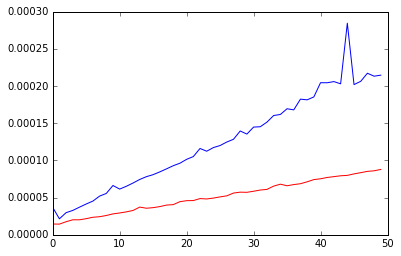

In [12]:
N = 50; repeats = 100
ltimes = getTimes(Lomuto_Partitioning, N, repeats)
htimes = getTimes(Hoare_Partitioning, N, repeats)
plt.plot(ltimes, 'b')
plt.plot(htimes, 'r')

For a brilliant theoretical exposition on the differences in speeds of the two algorithms, please refer to Sebastian Wild's [StackExchange answer](http://cs.stackexchange.com/a/11550). To summarize, the comparisons in case of both the algorithms are the same, however the number of swaps differ. It is expected that for swaps ($\sigma$):

$$\sigma_{Lomuto} = \frac{n}{2} - \frac{1}{2}$$
$$\sigma_{hoare} = \frac{n}{6} - \frac{1}{3}$$

There is a gap here. Going by the above formulae, Hoare Partitioning should have been about 3 times faster, if one goes by the number of swaps alone. It is a bit slower than that in practice. Clearly, the amount being spent on swaps is a fraction (granted, large) of the amount of time being spent on the sorting. 

Let us assume that beyond the swaps, there is an extra overhead factor $\lambda$ in both algorithms. Hence,

$$(\frac{\sigma_{Lomuto}}{\sigma_{Hoare}} = 3) \land (\frac{\sigma_{Lomuto} + \lambda}{\sigma_{Hoare} + \lambda} = \tau)$$
$$\Rightarrow \frac{3\sigma_{Hoare} + \lambda}{\sigma_{Hoare} + \lambda} = \tau$$
$$\Rightarrow \lambda = \frac{3 - \tau}{\tau - 1}\sigma_{Hoare}$$

The percentage of time spent swapping in Lomuto Partitioning is:
$$100\frac{\sigma_{Lomuto}}{\lambda + \sigma_{Lomuto}}$$ 
Similarly, for Hoare Partitioning,
$$100\frac{\sigma_{Hoare}}{\lambda + \sigma_{hoare}}$$

These work out to be:

In [13]:
# Let σ_hoare be 1. Hence, σ_lomuto = 3, and 
λ = (3 - τ)/(τ - 1)
100 * (3 / (λ + 3)), 100 * (1 / (λ + 1))

(88.58944375038288, 72.12884002409214)

As expected, Lomuto Partitioning is spending more time in swapping elements in comparison to Hoare Partitioning. What this calculation tells us is that in either case, most of the time in both algorithms is spent in swapping. Comparison operations on the other hand are not as significant.

These are partitioning schemes involving only a single pivot. Faster variants involving two pivots have been suggested by Sedgewick and Yaroslavskiy. Sebastian's paper [here](https://kluedo.ub.uni-kl.de/frontdoor/index/index/docId/3463) is a very interesting read and provides a very good perspective on the performance of the various partitioning schemes. 

As an aside, the default sort used in python and java is [TimSort](http://svn.python.org/projects/python/trunk/Objects/listsort.txt), which is a mergesort variant.